# Setup

Import necessary modules and do some basic setup.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np
import pandas as pd
import xarray as xr

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Custom utils
from utils import *

Define some paths and constants.

In [2]:
# Paths
DATADIR = os.getcwd() + '/../data'

# Some constants
G = 9.80665
CH_CENTER = [46.818, 8.228]
CH_BOUNDING_BOX = [45.66, 47.87, 5.84, 10.98]
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'

# Unsupervised learning approaches

## Getting started with the data

In [3]:
#Open data
mslp = xr.open_mfdataset(DATADIR + '/ERA5/Daymean_era5_2deg_MSL_EU_19790101-20210902.nc', combine='by_coords')

# Convert to hPa
mslp.MSL.values = mslp.MSL.values/100
lon = mslp.lon
lat = mslp.lat

mslp.MSL.shape

(15555, 25, 41)

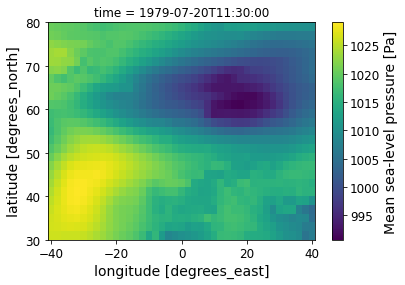

In [4]:
# Plot an example (day) of mslp
mslp.MSL.isel(time=200).plot();

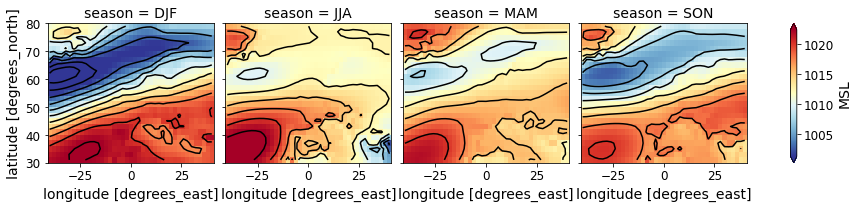

In [5]:
# Process season mean
seas_means = mslp.groupby("time.season").mean()

fg = seas_means.MSL.plot(col="season",  col_wrap=4,
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu_r)

# Use this to plot contours on each panel
# Note that this plotting call uses the original DataArray gradients
fg.map_dataarray(
    xr.plot.contour, x="lon", y="lat", colors="k", levels=13, add_colorbar=False
)

In [6]:
# Compute anomalies
climatology = mslp.mean('time')

# By season
season_climatology = mslp.groupby('time.season').mean('time')

# Climatological anomalies
anom_mslp =  mslp.MSL  - climatology

# By season
anom_seas_mslp = mslp.groupby('time.season') - season_climatology

## PCA

In [7]:
# Start using the whole data set for PCA. Then, anomalies can be used
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# We need to reshape the data [time,latxlon]  
mslp_stacked = mslp.stack(latlon=('lat', 'lon'))

# Load in memory for computing the PCA
mslp_stacked.load()

# Extract msl variable
X = mslp_stacked.MSL

In [8]:
# The number of variables (features) is 1025 (41 points in longitude * 25 points in latitude)
# Standardise the data
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)

In [9]:
# Do the PCA
pca = PCA()
pca.fit(X)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

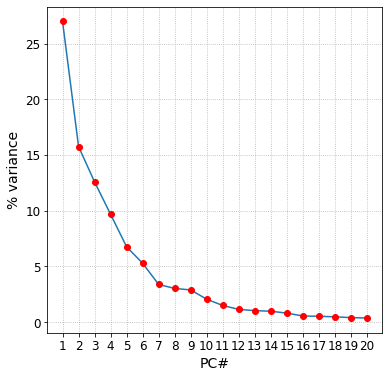

In [10]:
# See how many components 
f, ax = plt.subplots(figsize=(6,6))
ax.plot(range(1,21), pca.explained_variance_ratio_[0:20]*100)
ax.plot(range(1,21), pca.explained_variance_ratio_[0:20]*100,'ro')
ax.grid(ls=':')
ax.set_xticks(range(1,21)); 
ax.set_xlabel('PC#');
ax.set_ylabel("% variance");

In [11]:
# We can take 4 or 5
# Following the literature I will take 4 (e.g. Cortesi et a., 2021)
n = 12 # We can change this number
pca.explained_variance_ratio_[:n].sum()

0.90939635

In [12]:
PCs = pca.fit_transform(X)
PCs_n = PCs[:,:n]

# Data frame format for the selected components
PCdf = pd.DataFrame(PCs_n, index = mslp['time'], \
                    columns = ["PC%s" % (x) for x in range(1, PCs_n.shape[1] +1)])

# See the data
PCdf.head()

PC1        PC2       PC3        PC4        PC5  \
1979-01-01 11:30:00 -16.388958  11.987226 -5.626928   1.106520  -1.336244   
1979-01-02 11:30:00 -17.707655   3.619332 -6.971000   4.755783 -11.374018   
1979-01-03 11:30:00 -13.251779   3.883446 -1.273744   0.620547  -8.590671   
1979-01-04 11:30:00 -15.760398   0.768815 -0.849971  -7.507805   1.703094   
1979-01-05 11:30:00   3.909640  -9.706422 -8.834665 -14.672671  11.592617   

                           PC6        PC7        PC8       PC9       PC10  \
1979-01-01 11:30:00 -12.994725  10.724820  -2.927012  4.894493  -5.052362   
1979-01-02 11:30:00  -9.886306  -0.266932  -6.951045  3.870791  -3.145496   
1979-01-03 11:30:00   0.425252 -12.341117  -0.449025 -3.416316 -11.106291   
1979-01-04 11:30:00  13.102064  -2.133641  18.567621 -3.865487  -2.247265   
1979-01-05 11:30:00   3.109436  -4.015481  23.250673  1.646291   4.076118   

                          PC11      PC12  
1979-01-01 11:30:00  15.607113  2.389043  
1979-01-02 11:30:00  13.221449  2.142549  
1979-01-03 11:30:00  11.098979  5.238914  
1979-01-04 11:30:00   5.393679  7.974047  
1979-01-05 11:30:00   7.204882  7.357174

The EOFS (Empirical orthogonal functions) contain the spatial patterns associated with each PC

In [13]:
EOFs = pca.components_
EOFs = EOFs[:n,:]

# Reshape the data
EOFs_r = EOFs.reshape((n, len(lat), len(lon)))
EOFs_r.shape

(12, 25, 41)

In [14]:
nn = []
tot_var = []
for ip in range(n):
    xn = pca.explained_variance_ratio_[:ip + 1].sum()
    nn.append(xn)
    xx =  pca.explained_variance_ratio_[:ip + 1].sum() - pca.explained_variance_ratio_[:ip ].sum()
    tot_var.append(xx)

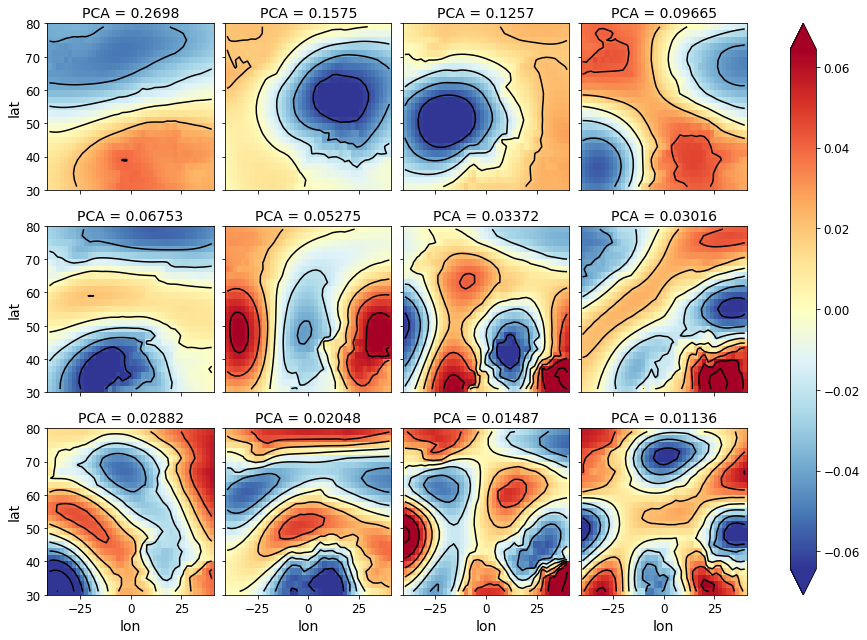

In [23]:
# Convert into Xarray for visualization
XD_EOFs_r = xr.DataArray(data=EOFs_r, coords=[("PCA", tot_var), ("lat", lat.data), ("lon", lon.data)])

fg = XD_EOFs_r.plot(col="PCA",  col_wrap=4,
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu_r)

# Use this to plot contours on each panel
# Note that this plotting call uses the original DataArray gradients
fg.map_dataarray(
    xr.plot.contour, x="lon", y="lat", colors="k", levels=13, add_colorbar=False
)

## K-means clustering

In [16]:
from sklearn.cluster import KMeans

# Perform K-cluster analysis using the PCds obtained before
nclusters = 12
kmeans = KMeans(init='k-means++', n_clusters=nclusters, n_init=10)
kmeans.fit(PCdf.values)
y_pred = kmeans.fit_predict(PCdf.values)

# Each day belongs to a cluster, labelled by kmeands.labels_
np.unique(kmeans.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [17]:
labels = pd.DataFrame(kmeans.labels_, index=mslp['time'], columns=['cluster'])

# See how many days belong to cluster 0
index = labels.query('cluster == {}'.format(0))
len(index)

1038

For each cluster we calculate the mean 

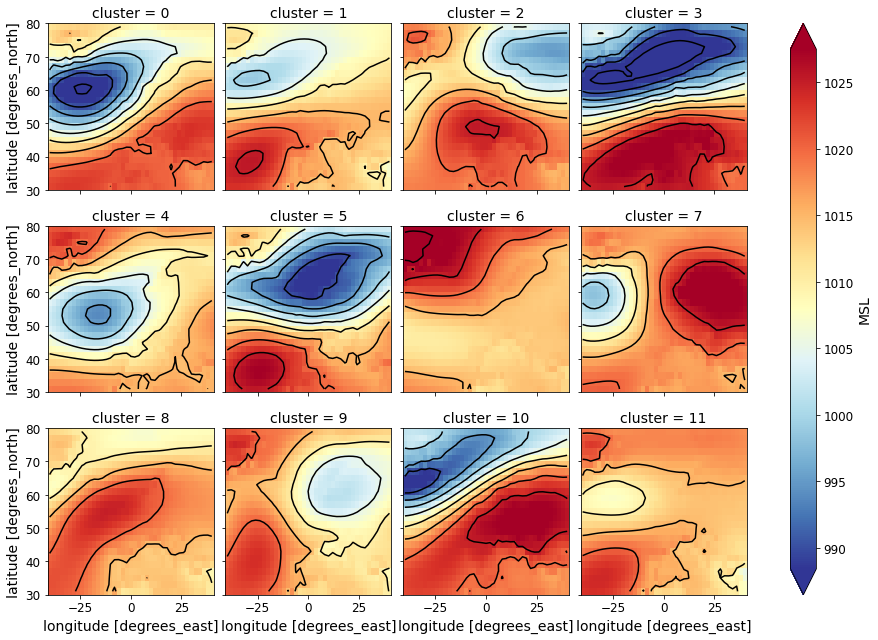

In [18]:
num_tot = len(labels.cluster)
clusters = []
nbdays = []

for iclus in range(nclusters): 
    index = labels.query('cluster == {}'.format(iclus)) 
    freq = (len(index)/num_tot)*100
    freq = round(freq,2)
    nbdays.append(freq)
    cluster = mslp.sel(time=index.index).mean('time')
    clusters.append(cluster)

clusters = xr.concat(clusters, dim='cluster')
clusters.assign_coords(cluster=nbdays)

fg_C = clusters.MSL.plot(col="cluster",  col_wrap=4,
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True, 
    cmap=mpl.cm.RdYlBu_r)

fg_C.map_dataarray(
    xr.plot.contour, x="lon", y="lat", colors="k", levels=13, add_colorbar=False
)

# Supervised learning approaches

## Data preparation: precipitation time series

**Dataset**: RhiresD, which is a gridded daily precipitation dataset over Switzerland provided by MeteoSwiss. It is based on a spatial interpolation of rain-gauge data. The grid resolution is 1 km, but the effective resolution is in the order of 15-20 km.


**Aggregations levels**: The gridded dataset has been averaged over different regions:
* 12 climatic regions
* 5 aggregated regions
* the whole country

In [19]:
# Read precipitation file and get events over threshold
precip = pd.read_csv(DATADIR + '/MeteoSwiss/precip_regions.csv')

df_time = pd.to_datetime({
    'year': precip.year,
    'month': precip.month,
    'day': precip.day})
precip.insert(0, "date", df_time, True)

precip = precip[(precip.date >= DATE_START) & (precip.date <= DATE_END)]

precip_p95 = precip.copy()
precip_p99 = precip.copy()

for key, ts in precip.iteritems():
    if key in ['year', 'month', 'day']: continue
    precip_p95[key] = ts > ts.quantile(0.95)
    precip_p99[key] = ts > ts.quantile(0.99)

## Linear regression for precipitation values

In [21]:
# Open data and get the mean value over Switzerland
z = get_era5_data(DATADIR + '/ERA5/geopotential/*.nc', DATE_START, DATE_END)
z500_mean = get_data_mean_over_CH_box(z, 500)
mslp = get_era5_data(DATADIR + '/ERA5/mslp/*.nc', DATE_START, DATE_END)
mslp_mean = get_data_mean_over_CH_box(mslp)
t2m = get_era5_data(DATADIR + '/ERA5/Daymean_era5_T2M_EU_19790101-20210905.nc', DATE_START, DATE_END)
t2m_mean = get_data_mean_over_CH_box(t2m)

# Convert to geopotential height and hPa
z500_mean['z'] = z500_mean['z'] / G
mslp_mean['MSL'] = mslp_mean['MSL'] / 100

Extracting data for the period 1979-01-01 - 2019-12-31
Extracting data for the period 1979-01-01 - 2019-12-31
Extracting data for the period 1979-01-01 - 2019-12-31


In [24]:
# Plot the time series
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
z500_mean.z.plot(ax=axs[0])
axs[0].set_title('Geopotentiel 500hPa')
mslp_mean.MSL.plot(ax=axs[1])
axs[1].set_title('Sea level pressure')
t2m_mean.T2MMEAN.plot(ax=axs[2])
axs[2].set_title('Temperature 2m')

In [ ]:
from sklearn.model_selection import train_test_split

full_set = [z500_mean, mslp_mean, t2m_mean, precip]

#train_set, test_set = train_test_split(full_set, test_size=0.2, random_state=42)

## Logistic regression for extreme events

## Random forest

# Deep learning approaches